In [1]:
import sys
print("Python version:", sys.version)

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [2]:
!pip install pyspark

In [3]:
!apt install openjdk-8-jdk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common librsvg2-common libxcomposite1 libxt-dev
  libxtst6 libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless session-migration x11-utils
Suggested packages:
  gvfs libxt-doc openjdk-8-demo openjdk-8-source visualvm libnss-mdns
  fonts-nanum fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 

ΘΕΜΑ 1

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, substring, desc
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import time
import csv, io

# Creation of Spark session
spark = SparkSession.builder.master("local[*]").appName("FlightDelayAnalytics").getOrCreate()

sc = spark.sparkContext
print("Spark session started")

# upload file helper
def get_csv_path():
    try:
        # Colab / IPython upload
        from google.colab import files
        uploaded = files.upload()
        if uploaded:
            return list(uploaded.keys())[0]
    except Exception:
        pass
    # fallback: ask for path
    path = input("Please give the path: ").strip()
    return path

csv_path = get_csv_path() # file load

NUM_RUNS = 5

# Time lists
rdd_times = {'total': [], 'action': []}

def calculate_average_time(times_list):

    if len(times_list) < 3:
        return 0.0
    sorted_times = sorted(times_list)
    avg = sum(sorted_times[1:-1]) / 3
    return avg

def print_time_results(times_dict, api_name):

    print(f"\n ---Counting time results ({api_name})---")
    print(f"All {NUM_RUNS} runs:")
    print(f"  Total Time (Total):  {times_dict['total']}")
    print(f"  First Action Time (Lazy): {times_dict['action']}")

    avg_total = calculate_average_time(times_dict['total'])
    avg_action = calculate_average_time(times_dict['action'])

    print("-------------------------------------------------")
    print(f"Average of 3 middle runs (Total):  {avg_total:.4f} sec.")
    print(f"Average of 3 middle runs (Action): {avg_action:.4f} sec.")
    print("-------------------------------------------------")

Spark session started


Saving flights_2000.csv to flights_2000.csv


In [5]:
def analyze_rdd():

  # Delay Analysis per airport using RDD API

  flights_rdd = sc.textFile(csv_path) # Reading file as RDD
  header = flights_rdd.first()

  # Cleaning and parsing

  data_rdd = flights_rdd.filter(lambda row: row != header).map(lambda line: line.split(','))
  pairs_rdd = data_rdd.filter(lambda fields: fields[10] == "0" and fields[6] != "" ).map(lambda fields: (fields[3], float(fields[6]))) # (ORIGIN_AIRPORT, DEP_DELAY)

  # Average delay calculation with combine by key

  # createCombiner: (sum, count)
  create_combiner = lambda delay: (delay, 1)
  merge_value = lambda acc, delay: (acc[0] + delay, acc[1] + 1)
  merge_combiners = lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])

  sum_count_rdd = pairs_rdd.combineByKey(
       create_combiner,
        merge_value,
        merge_combiners)

  average_delay_rdd = sum_count_rdd.mapValues(
        lambda sum_count: sum_count[0] / sum_count[1])

  final_rdd_to_action = average_delay_rdd.map(lambda x: (x[1], x[0])).sortByKey(False)
  start_time = time.time()
  top10_rdd = final_rdd_to_action.take(10)

  end_time = time.time()
  time_action = end_time - start_time

  return time_action, top10_rdd

In [6]:
# Running RDD 5 times - Time calculation

print("SPARK RDD API - TOP 10 Airports")

for i in range(NUM_RUNS):
    start_time_total = time.time()

    time_action, result = analyze_rdd()

    end_time_total = time.time()
    time_total = end_time_total - start_time_total

    rdd_times['total'].append(time_total)
    rdd_times['action'].append(time_action)

    print(f"\n--- RDD Run {i+1} ---")
    print(f"Total Time: {time_total:.4f}s | Action Time: {time_action:.4f}s")

print("\n RDD Top 10 Airports (Last Run)")
print("Airport | Average delay (minutes)")
print("---------------------------------")
for delay, airport in result:
    print(f"{airport:10} | {delay:.2f}")

print_time_results(rdd_times, "RDD API")

SPARK RDD API - TOP 10 Airports

--- RDD Run 1 ---
Total Time: 7.8896s | Action Time: 0.9604s

--- RDD Run 2 ---
Total Time: 2.4728s | Action Time: 0.7503s

--- RDD Run 3 ---
Total Time: 2.1209s | Action Time: 0.7093s

--- RDD Run 4 ---
Total Time: 2.1900s | Action Time: 0.7377s

--- RDD Run 5 ---
Total Time: 3.1032s | Action Time: 1.4176s

 RDD Top 10 Airports (Last Run)
Airport | Average delay (minutes)
---------------------------------
DFW        | 11.98
JFK        | 11.20
SEA        | 9.56
ORD        | 9.35
LAS        | 9.11
CLT        | 8.82
MCO        | 8.69
BOS        | 8.63
DEN        | 8.44
MIA        | 8.26

 ---Counting time results (RDD API)---
All 5 runs:
  Total Time (Total):  [7.889591932296753, 2.4727847576141357, 2.1209254264831543, 2.1900322437286377, 3.1032445430755615]
  First Action Time (Lazy): [0.9604089260101318, 0.7503211498260498, 0.7093315124511719, 0.7377035617828369, 1.417595386505127]
-------------------------------------------------
Average of 3 middle ru

ΘΕΜΑ 2

In [7]:
# Reading csv file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving flights_2000.csv to flights_2000 (1).csv
User uploaded file "flights_2000 (1).csv" with length 146556 bytes


In [8]:
file_name = "flights_2000.csv"

# Reading file in DataFrame
df = spark.read.csv(file_name, header=True, inferSchema=True)

print(f"File '{file_name}' loaded into Spark DataFrame")

File 'flights_2000.csv' loaded into Spark DataFrame


In [9]:
print("DataFrame Schema")
df.printSchema()

DataFrame Schema
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DEST_AIRPORT: string (nullable = true)
 |-- SCHED_DEP: timestamp (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- SCHED_ARR: timestamp (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- DIST_KM: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)



In [10]:
# Filtering and nulls cleaning
cleaned_df = df.filter(col("CANCELLED") == 0).na.drop(subset=["DEP_DELAY"])

# Grouping by flight route and aggregation calculating average delay
avg_delays_df = cleaned_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT").agg(avg("DEP_DELAY").alias("avg_delay"))
sorted_delays_df = avg_delays_df.orderBy(desc("avg_delay"))
# Saving top 10 routes with the biggest average delay in DataFrame
top_10_routes_df = sorted_delays_df.limit(10)

print("Top 10 Routes with biggest average delay")
top_10_routes_df.show()

Top 10 Routes with biggest average delay
+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|         avg_delay|
+--------------+------------+------------------+
|           DFW|         JFK|              23.3|
|           JFK|         LAS|              22.8|
|           MIA|         JFK|              20.5|
|           MCO|         ORD|19.818181818181817|
|           MCO|         LAX|19.142857142857142|
|           BOS|         SEA|18.857142857142858|
|           DFW|         ATL|            18.625|
|           BOS|         PHX|18.181818181818183|
|           JFK|         MIA|              18.0|
|           DEN|         SFO|17.857142857142858|
+--------------+------------+------------------+



In [11]:
output_folder_name = "out/top_10_routes_csv"

top_10_routes_df.write.mode("overwrite").csv(output_folder_name)

print(f"Results were saved to folder: {output_folder_name}")

Results were saved to folder: out/top_10_routes_csv


In [12]:
def run_dataframe_analysis():

  total_start_time = time.time()

  df = spark.read.csv(file_name, header=True, inferSchema=True)

  cleaned_df = df.filter(col("CANCELLED") == 0).na.drop(subset=["DEP_DELAY"])

  avg_delays_df = cleaned_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT").agg(avg("DEP_DELAY").alias("avg_delay"))
  sorted_delays_df = avg_delays_df.orderBy(desc("avg_delay"))
  analysis_df = sorted_delays_df.limit(10)

  action_start_time = time.time()

  analysis_df.show()

  action_end_time = time.time()
  total_end_time = time.time()

  total_time = total_end_time - total_start_time
  action_time = action_end_time - action_start_time

  return total_time, action_time

total_times = []
action_times = []

print("DataFrame Analysis 5 times")

for i in range(5):
  total_t, action_t = run_dataframe_analysis()
  print(f"Run {i+1}: Total={total_t:.4f}s, Action={action_t:.4f}s")
  total_times.append(total_t)
  action_times.append(action_t)

print("\n--- Time results (DataFrame) ---")
print(f"Total Time: {total_times}")
print(f"Action Time: {action_times}")

total_times.sort()
action_times.sort()

avg_total_time = sum(total_times[1:4]) / 3
avg_action_time = sum(action_times[1:4]) / 3

print(f"Average Total Time (3/5 runs): {avg_total_time:.4f}s")
print(f"Average Action Time (3/5 runs): {avg_action_time:.4f}s")

DataFrame Analysis 5 times
+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|         avg_delay|
+--------------+------------+------------------+
|           DFW|         JFK|              23.3|
|           JFK|         LAS|              22.8|
|           MIA|         JFK|              20.5|
|           MCO|         ORD|19.818181818181817|
|           MCO|         LAX|19.142857142857142|
|           BOS|         SEA|18.857142857142858|
|           DFW|         ATL|            18.625|
|           BOS|         PHX|18.181818181818183|
|           JFK|         MIA|              18.0|
|           DEN|         SFO|17.857142857142858|
+--------------+------------+------------------+

Run 1: Total=1.4907s, Action=0.6943s
+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|         avg_delay|
+--------------+------------+------------------+
|           DFW|         JFK|              23.3|
|           JFK|         LAS|              22.8|
|   

ΘΕΜΑ 4

Spark DataFrame (Top 10) transition to Pandas DataFrame
Transition finished
  ORIGIN_AIRPORT DEST_AIRPORT  avg_delay
0            DFW          JFK  23.300000
1            JFK          LAS  22.800000
2            MIA          JFK  20.500000
3            MCO          ORD  19.818182
4            MCO          LAX  19.142857
5            BOS          SEA  18.857143
6            DFW          ATL  18.625000
7            BOS          PHX  18.181818
8            JFK          MIA  18.000000
9            DEN          SFO  17.857143
Chart saved as: out/top_10_routes_chart.png


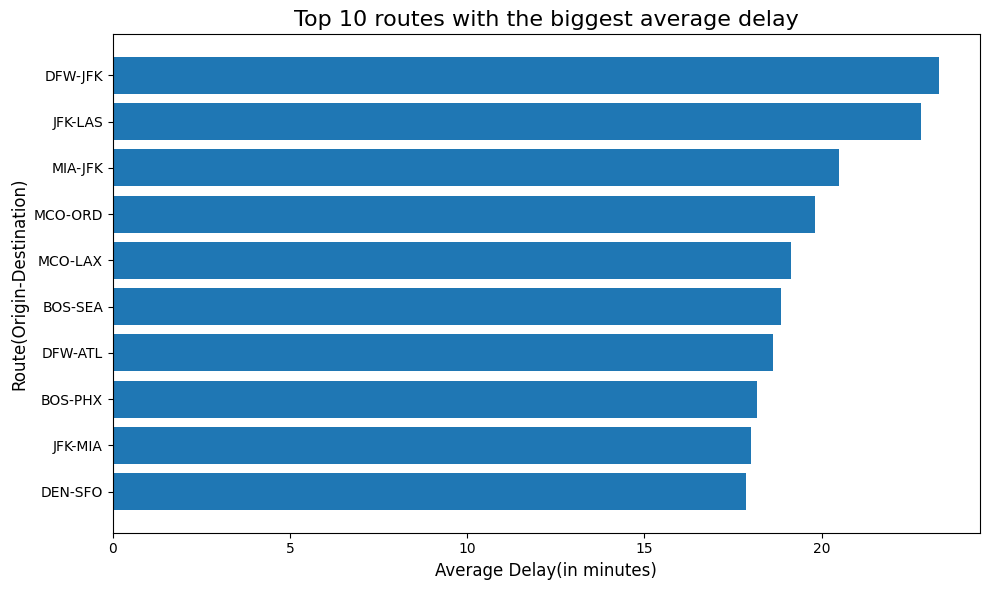

In [13]:
import matplotlib.pyplot as pl

print("Spark DataFrame (Top 10) transition to Pandas DataFrame")
# Spark to Pandas transition
pandas_df = top_10_routes_df.toPandas()
print("Transition finished")
print(pandas_df)

# Creation of route
pandas_df['route'] = pandas_df['ORIGIN_AIRPORT'] + '-' + pandas_df['DEST_AIRPORT']

pandas_df_sorted = pandas_df.sort_values(by='avg_delay', ascending=True)

pl.figure(figsize=(10, 6))

pl.barh(
  pandas_df_sorted['route'],
  pandas_df_sorted['avg_delay']
)

pl.title('Top 10 routes with the biggest average delay', fontsize=16)
pl.xlabel('Average Delay(in minutes)', fontsize=12)
pl.ylabel('Route(Origin-Destination)', fontsize=12)

pl.tight_layout()

output_chart_name = "out/top_10_routes_chart.png"
pl.savefig(output_chart_name)

print(f"Chart saved as: {output_chart_name}")
pl.show()

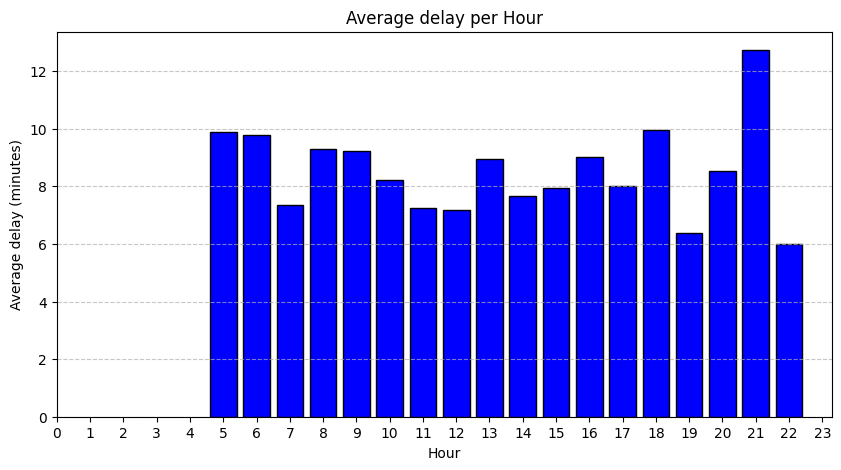

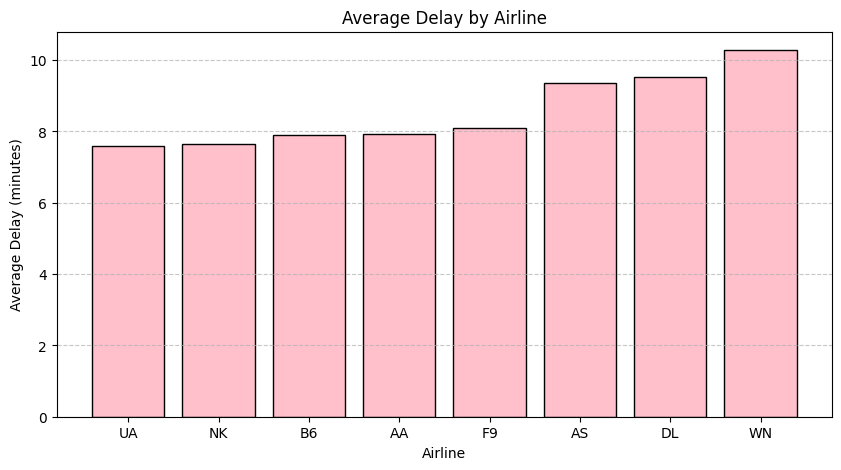

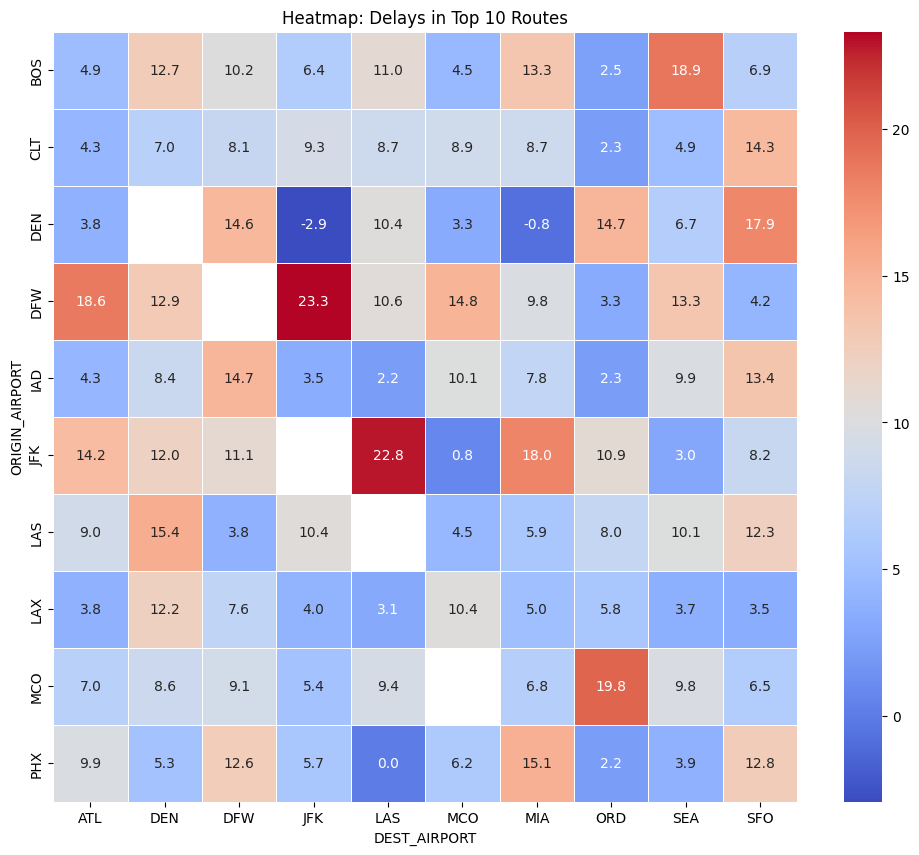

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import substring, col, avg, count

# Creating of column HOUR in DataFrame
df_with_hour = cleaned_df.withColumn("HOUR", substring(col("SCHED_DEP"), 12, 2).cast("int"))

# Grouping by hour and average calculation
hourly_df = df_with_hour.groupBy("HOUR") \
                        .agg(avg("DEP_DELAY").alias("avg_delay")) \
                        .orderBy("HOUR")

hourly_pdf = hourly_df.toPandas()

# Bar Chart creation
plt.figure(figsize=(10, 5))
plt.bar(hourly_pdf['HOUR'], hourly_pdf['avg_delay'], color='blue', edgecolor='black')
plt.xlabel("Hour")
plt.ylabel("Average delay (minutes)")
plt.title("Average delay per Hour")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("out/plot_a_hourly.png")
plt.show()

# Grouping by AIRLINE
airline_df = cleaned_df.groupBy("AIRLINE") \
                       .agg(avg("DEP_DELAY").alias("avg_delay")) \
                       .orderBy("avg_delay")

airline_pdf = airline_df.toPandas()

plt.figure(figsize=(10, 5))
plt.bar(airline_pdf['AIRLINE'], airline_pdf['avg_delay'], color='pink', edgecolor='black')
plt.xlabel("Airline")
plt.ylabel("Average Delay (minutes)")
plt.title("Average Delay by Airline")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("out/plot_b_airline.png")
plt.show()

# For every unique route
routes_df = cleaned_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT") \
                      .agg(avg("DEP_DELAY").alias("avg_delay"))

routes_pdf = routes_df.toPandas()

top_origins = routes_pdf['ORIGIN_AIRPORT'].value_counts().head(10).index
top_dests = routes_pdf['DEST_AIRPORT'].value_counts().head(10).index

filtered_routes = routes_pdf[
    (routes_pdf['ORIGIN_AIRPORT'].isin(top_origins)) &
    (routes_pdf['DEST_AIRPORT'].isin(top_dests))
]

# List to matrix
heatmap_data = filtered_routes.pivot_table(index='ORIGIN_AIRPORT',
                                           columns='DEST_AIRPORT',
                                           values='avg_delay')

# Seaborn usage
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", linewidths=.5)
plt.title("Heatmap: Delays in Top 10 Routes")
plt.savefig("out/plot_c_heatmap.png")
plt.show()

In [15]:
!zip -r results.zip out/

  adding: out/ (stored 0%)
  adding: out/plot_b_airline.png (deflated 19%)
  adding: out/plot_a_hourly.png (deflated 20%)
  adding: out/top_10_routes_csv/ (stored 0%)
  adding: out/top_10_routes_csv/.part-00000-9ca5dc64-fe3d-4ebe-9f5e-9bcd39c9ee0e-c000.csv.crc (stored 0%)
  adding: out/top_10_routes_csv/_SUCCESS (stored 0%)
  adding: out/top_10_routes_csv/part-00000-9ca5dc64-fe3d-4ebe-9f5e-9bcd39c9ee0e-c000.csv (deflated 41%)
  adding: out/top_10_routes_csv/._SUCCESS.crc (stored 0%)
  adding: out/top_10_routes_chart.png (deflated 18%)
  adding: out/plot_c_heatmap.png (deflated 10%)
